In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(
    host = "localhost",
    username = "root",
    password = "******",
    database = "ecommerce"
)

cur = db.cursor()

# List all unique cities where customers are located.

In [25]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=["Customer_city"])
df

,Customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


# Count the number of orders placed in 2017.


In [5]:
query = """ select count(order_id) from orders where year (order_purchase_timestamp)= 2017"""

cur.execute(query)

data = cur.fetchall()

"Total orders placed in 2017 are" ,data[0][0]

('Total orders placed in 2017 are', 45101)

# Find the total sales per category.

In [5]:
query = """ select upper(products.product_category) as Category, round(sum(payments.payment_value),2) as Sales
            from products
            join order_items
            on products.product_id = order_items.product_id
            join payments
            on payments.order_id = order_items.order_id
            group by category 
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Category","Sales"])
df                  

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,FASHION BAGS AND ACCESSORIES,218158.28
4,BED TABLE BATH,1712553.67
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [16]:
query = """ select (sum(case when payment_installments >= 1 then 1 
           else 0 end ))/count(*)*100 from payments; """

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments is",data[0][0]

('The percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.

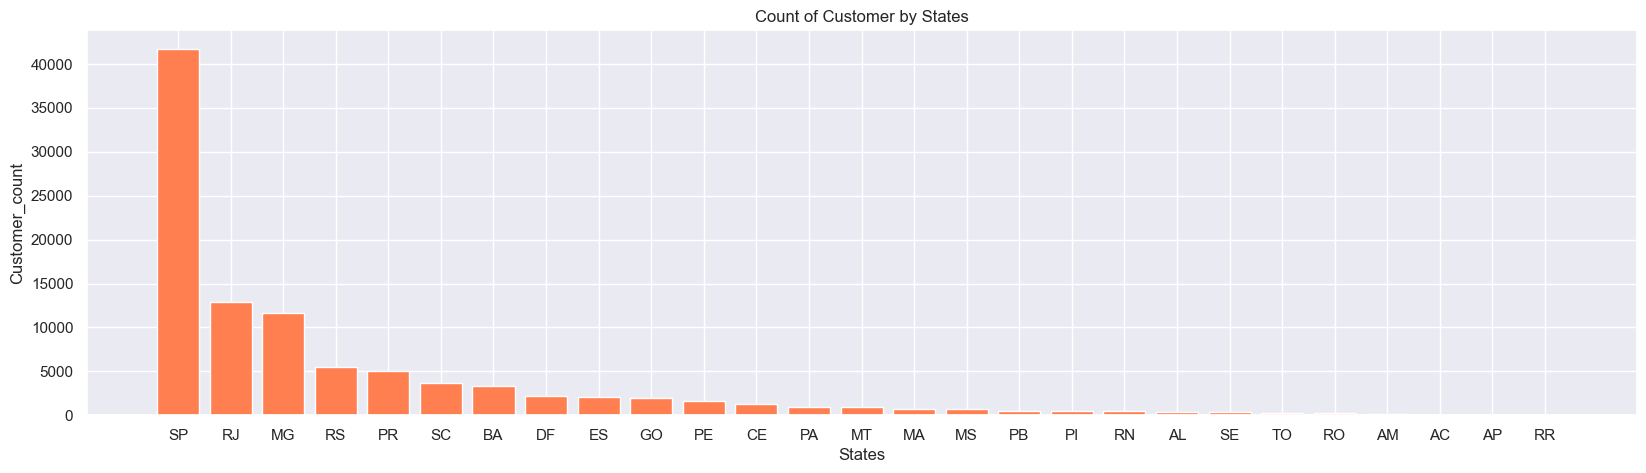

In [79]:
query = """ select customer_state ,count(customer_id)
            from customers 
            group by customer_state
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Customer_state","Customer_count"])
df= df.sort_values(by = "Customer_count", ascending=False)


plt.bar(df["Customer_state"],df["Customer_count"],color="Coral")
sns.set(rc={'figure.figsize':(20,5)})
plt.xlabel("States")
plt.ylabel("Customer_count")
plt.title("Count of Customer by States")
plt.show()

# Calculate the number of orders per month in 2018.

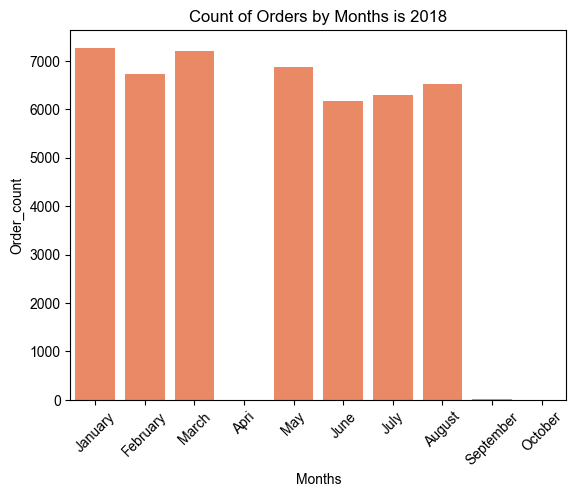

In [8]:
query = """ select monthname(order_purchase_timestamp) as Months , count(order_id) as Order_count
            from orders
            where year(order_purchase_timestamp) = 2018
            group by Months
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=["Months","Order_count"])
o = ["January", "February", "March", "Apri", "May", "June", "July", "August", "September", "October"]
sns.barplot(x=df ["Months"] , y=df["Order_count"],data=df , order= o,color="Coral")
sns.set(rc={'figure.figsize':(10,5)})
plt.xticks(rotation=45)
plt.title("Count of Orders by Months is 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [13]:
query = """ with count_per_order as
            (select orders.order_id,orders.customer_id,count(order_items.order_id) as oc
            from orders
            join order_items
            on orders.order_id = order_items.order_id
            group by orders.order_id,orders.customer_id)


            select customers.customer_city,round(avg(count_per_order.oc),2) as Average_order
            from customers
            join count_per_order
            on customers.customer_id = count_per_order.customer_id
            group by customers.customer_city
            order by Average_order desc
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame (data , columns = ["Customer_city","Average_products / Order"])
df

,Customer_city,Average_products / Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
...,...,...
4105,sebastiao leal,1.00
4106,morro agudo de goias,1.00
4107,santa filomena,1.00
4108,guamiranga,1.00


# Calculate the percentage of total revenue contributed by each product category.

In [4]:
query = """ select upper(products.product_category) as category , round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) as sales
            from products
            join order_items
            on products.product_id = order_items.product_id
            join payments
            on payments.order_id = order_items.order_id
            group by category
            order by sales desc;
        """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame (data , columns = ["Category","Percentage Distribution"])
df

,Category,Percentage Distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [13]:
query = """ select upper(products.product_category),count(order_items.product_id),round(avg(order_items.price),2)
            from products
            join order_items
            on products.product_id = order_items.product_id
            group by products.product_category 
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame (data,columns = [" Category","Order_count","Price"])

arr1 = df["Order_count"]
arr2 = df["Price"]

np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.

In [14]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
            (select order_items.seller_id,round(sum(payments.payment_value),2) as revenue
            from order_items
            join payments
            on order_items.order_id = payments.order_id
            group by order_items.seller_id) as a
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame (data,columns = [" Seller_id","Revenue","Rank"])
df

,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.21,3076
3091,702835e4b785b67a084280efca355756,18.56,3077
3092,4965a7002cca77301c82d3f91b82e1a9,16.36,3078
3093,77128dec4bec4878c37ab7d6169d6f26,15.22,3079


 # Calculate the moving average of order values for each customer over their order history.

In [18]:
query = """ select customer_id, order_purchase_timestamp,payment,
            avg(payment) over(partition by customer_id order by order_purchase_timestamp 
            rows between 2 preceding and current row) as mov_avg
            from
            (select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
            from payments 
            join orders
            on payments.order_id = orders.order_id) as a;
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame (data,columns = [" Customer_id","Order_purchase_timestamp","Payment","Mov_avg"])
df

,Customer_id,Order_purchase_timestamp,Payment,Mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

In [19]:
query = """ select Years,Months,Payment,sum(payment)
            over(order by Years,Months) as Cumulative_Sales
            from
            (select year(orders.order_purchase_timestamp) as Years,
            month(orders.order_purchase_timestamp) as Months,
            round(sum(payments.payment_value),2) as Payment 
            from orders 
            join payments
            on orders.order_id = payments.order_id
            group by Years,Months 
            order by Years,Months) as a; 
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame (data,columns = ["Years ","Months","Payment","Cumulative_Sales"])
df

,Years,Months,Payment,Cumulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


 # Calculate the year-over-year growth rate of total sales.

In [20]:
query = """ select Years, ((Payment - lag(Payment,1) over(order by Years)) / lag(Payment,1) over(order by Years)) * 100 YOY_Per_Growth 
            from 
            (select year(orders.order_purchase_timestamp) as Years,
            round(sum(payments.payment_value),2) as Payment 
            from orders 
            join payments
            on orders.order_id = payments.order_id
            group by Years
            order by Years) as a
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame (data,columns = ["Years ","YOY % Growth"])
df

,Years,YOY % Growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


  # Identify the top 3 customers who spent the most money in each year.


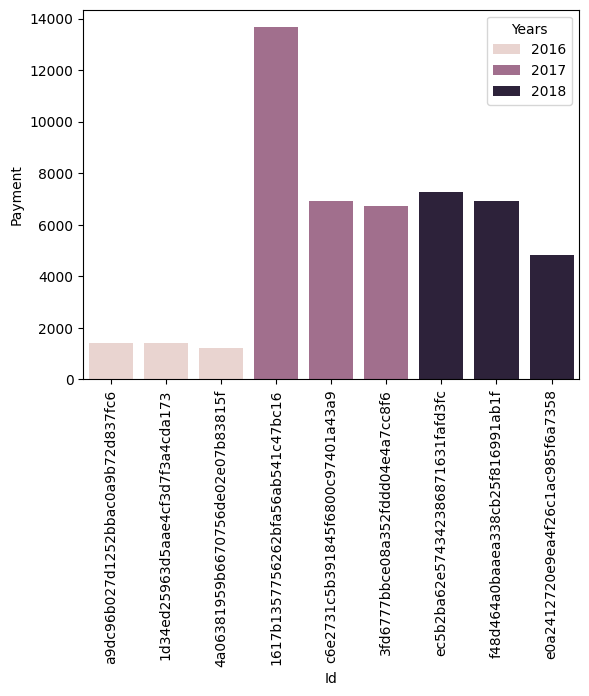

In [28]:
query = """ select years, customer_id,payment,D_rank
            from
            (select year(orders.order_purchase_timestamp) as Years,orders.customer_id,sum(payments.payment_value) as payment,
            dense_rank() over(partition by year(orders.order_purchase_timestamp)
            order by sum(payments.payment_value)desc) D_rank
            from orders
            join payments
            on payments.order_id = orders.order_id
            group by  year(orders.order_purchase_timestamp),orders.customer_id) as a
            where D_rank <=3
        """

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame (data,columns = ["Years","Id","Payment","Rank"])
sns.barplot(x = "Id" , y = "Payment", data = df , hue = "Years")
plt.xticks(rotation = 90)
plt.show()